# Task 1.5: Dimensionality Reduction

The goal of this notebook is to reduce token trajectories (the high-dimensional embeddings across layers, i.e. the residual stream) into a shared 2D space for visualization using PCA.

- **PCA (Principal Component Analysis)** is a dimensionality reduction technique that helps reduce the number of data dimensions (e.g. features) while keeping as much variation as possible. In our case, PCA finds the directions where token embeddings vary the most and projects embeddings onto those directions, so we can watch tokens move through model space in 2D.

## Model and Task Preparation (including `get_token_trajectory()` from Task 1.4)


In [1]:
from transformer_lens import HookedTransformer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import umap
import warnings

# To suppress UserWarning messages
warnings.filterwarnings("ignore", category=UserWarning)

model = HookedTransformer.from_pretrained("gpt2-small")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
def get_token_trajectory(text: str, token_index: int) -> list[dict]:
    
    """
    Returns the residual stream vector for one token at each layer.
    """
    
    _, cache = model.run_with_cache(text)
    n_layers = model.cfg.n_layers # 12 for GPT-2 small
    trajectory = []
    
    for layer in range(n_layers):
        embedding = cache["resid_post", layer][0, token_index, :] # shape (768,)
        trajectory.append({
            "layer": layer,
            "embedding": embedding.tolist() # convert tensor to list
        })
        
    return trajectory

#### Quick Check

In [3]:
token_traj = get_token_trajectory("I can do it!", 2)
print(len(token_traj), "layers," , len(token_traj[0]["embedding"]), "dimension embedding")

12 layers, 768 dimension embedding


## `reduce_trajectories()` - Dimensionality Reduction with PCA

This function takes in token trajectories and projects them into a shared 2D space for easier visualization. The trajectory of each token contains a 768-dimensional residual stream vector at every layer. Instead of reducing tokens separately, all embeddings are combined into one matrix to apply a joint PCA. Since every token is projected into the same coordinate system, we can compare how each token’s representation changes across layers as it moves through the model.

In [4]:
def reduce_trajectories(trajectories: dict[int, list]) -> dict[int, list[dict]]:
    
    """
    Input: {token_index: [768-dim embedding per layer]}
    Output: {token_index: [{layer, x, y} per layer]}
    All tokens share the same PCA space so trajectories are comparable.
    """
    
    # Collect ALL embeddings into one matrix for joint PCA
    # to see multiple tokens moving in the same space
    all_embeddings = []
    labels = [] # (token_index, layer) pairs
    
    for token_idx, layers in trajectories.items():
        for layer_data in layers:
            all_embeddings.append(layer_data["embedding"])
            labels.append((token_idx, layer_data["layer"]))
            
    all_embeddings = np.array(all_embeddings)
    
    pca = PCA(n_components=2)
    # Fit the model with all_embeddings and apply the dimensionality reduction on all_embeddings.
    coords_2d = pca.fit_transform(all_embeddings)  # shape: (number_of_points, 2)
    
    # Reconstruct per-token trajectories with 2D coordinates
    result = {}
    
    for i, (token_idx, layer) in enumerate(labels):
        if token_idx not in result:
            result[token_idx] = []
            
        result[token_idx].append({
            "layer": layer,
            "x": float(coords_2d[i, 0]),
            "y": float(coords_2d[i, 1])
        })
            
    return result

## Test: reduce 2-3 tokens from the sentence "The cat sat on the mat"

### Confirm trajectories with " cat"

In [5]:
text = "The cat sat on the mat"
tokens = model.to_str_tokens(text)
print("Tokens:", list(enumerate(tokens)))

# token index for " cat" should be 2 with default prepend_bos
cat_idx = tokens.index(" cat")
cat_traj = get_token_trajectory(text, cat_idx)

print("\nChecking ' cat' trajectory:\n")

for item in cat_traj:
    layer = item["layer"]
    embedding = np.array(item["embedding"])
    print(f"Layer {layer:2d} : shape={embedding.shape} | first5={embedding[:5]}")

Tokens: [(0, '<|endoftext|>'), (1, 'The'), (2, ' cat'), (3, ' sat'), (4, ' on'), (5, ' the'), (6, ' mat')]

Checking ' cat' trajectory:

Layer  0 : shape=(768,) | first5=[ 0.07512654 -0.64897388 -0.04039529  1.4727509   0.01203611]
Layer  1 : shape=(768,) | first5=[ 0.78628385 -0.23651142  0.14196488  1.97202516 -0.20104246]
Layer  2 : shape=(768,) | first5=[1.55775332 0.00352249 0.92276752 2.56098747 0.08710366]
Layer  3 : shape=(768,) | first5=[2.09653854 0.00611505 1.13636255 3.2210145  0.59773636]
Layer  4 : shape=(768,) | first5=[1.61327016 0.05104441 0.39688909 2.75178123 0.00341374]
Layer  5 : shape=(768,) | first5=[1.91860187 0.83885026 1.25525522 2.33710456 0.23676708]
Layer  6 : shape=(768,) | first5=[2.08818078 0.69587213 1.03554261 3.56954241 0.53626108]
Layer  7 : shape=(768,) | first5=[2.34455848 0.69076145 2.13535213 2.82393885 0.65275764]
Layer  8 : shape=(768,) | first5=[1.82197988 0.49273941 1.91632223 3.73615885 0.02466387]
Layer  9 : shape=(768,) | first5=[ 0.167796

### Reduce the dimensions of 2-3 tokens from the same sentence

In [6]:
token_indices = {
    tokens.index(" cat"): " cat",
    tokens.index(" sat"): " sat",
    tokens.index(" mat"): " mat",
}

raw_trajectories = {
    idx: get_token_trajectory(text, idx) 
    for idx in token_indices
}

reduced_traj = reduce_trajectories(raw_trajectories)

# quick check: should be 12 points each
for idx, label in token_indices.items():
    print(label, "'s points:", len(reduced_traj[idx]))

 cat 's points: 12
 sat 's points: 12
 mat 's points: 12


In [7]:
# Inspect the reduced results
for token_idx, trajectory in reduced_traj.items():
    
    token_name = token_indices[token_idx]
    
    print(f"\nToken '{token_name}' (index {token_idx}):")
    
    for point in trajectory:
        print(f"  Layer {point['layer']:2d} → x={point['x']:.4f}, y={point['y']:.4f}")


Token ' cat' (index 2):
  Layer  0 → x=-67.8518, y=9.4001
  Layer  1 → x=-71.1444, y=11.3097
  Layer  2 → x=-65.8493, y=17.9552
  Layer  3 → x=-61.8866, y=23.7411
  Layer  4 → x=-59.1187, y=27.9096
  Layer  5 → x=-54.6031, y=33.2084
  Layer  6 → x=-43.7760, y=42.3728
  Layer  7 → x=-26.3883, y=55.1057
  Layer  8 → x=-6.8434, y=72.0746
  Layer  9 → x=24.4738, y=89.0232
  Layer 10 → x=102.4448, y=116.2768
  Layer 11 → x=214.9425, y=95.8500

Token ' sat' (index 3):
  Layer  0 → x=-67.0847, y=-18.5115
  Layer  1 → x=-71.4097, y=-23.0596
  Layer  2 → x=-68.0691, y=-24.3655
  Layer  3 → x=-62.9030, y=-24.8042
  Layer  4 → x=-59.6293, y=-25.6209
  Layer  5 → x=-51.6788, y=-25.2342
  Layer  6 → x=-40.0402, y=-25.3508
  Layer  7 → x=-27.4074, y=-28.2477
  Layer  8 → x=-4.2258, y=-31.5273
  Layer  9 → x=31.4947, y=-30.8846
  Layer 10 → x=136.6289, y=-18.0342
  Layer 11 → x=372.6940, y=-49.5586

Token ' mat' (index 6):
  Layer  0 → x=-71.3547, y=-14.5138
  Layer  1 → x=-73.0397, y=-18.2464
  Lay

## Visualization: Token Trajectories with PCA
This plot shows the 2D PCA projection of token trajectories across GPT-2 small layers, where each point is the residual stream embedding of a token at a specific layer. The connected points form a path showing how the token representation changes through the model. The goal here is more about comparing the relative patterns between tokens rather than interpreting the exact coordinates.

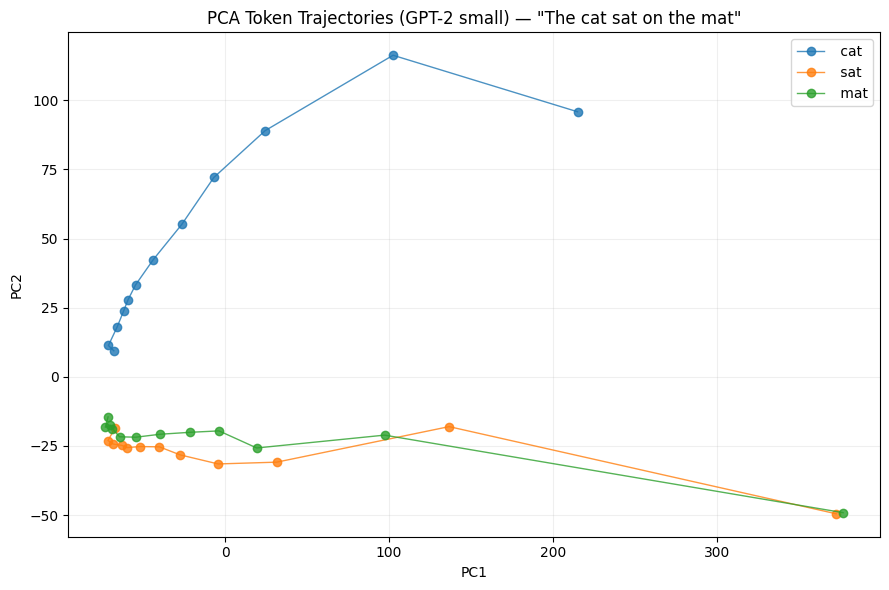

Saved plot: token_trajectories_pca_Steven.png


In [8]:
plt.figure(figsize=(9, 6))

for idx, label in token_indices.items():
    xs = [p["x"] for p in reduced_traj[idx]]
    ys = [p["y"] for p in reduced_traj[idx]]

    # connected path + points
    plt.plot(xs, ys, marker="o", linewidth=1, alpha=0.8, label=label)

plt.title(f"PCA Token Trajectories (GPT-2 small) — \"{text}\"")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("token_trajectories_pca_Steven.png", dpi=150)
plt.show()

print("Saved plot: token_trajectories_pca_Steven.png")

## Observations
- Each token has a different trajectory, showing that its residual stream representation evolves differently across layers.
- ' cat' moves strongly upward in PC2, suggesting certain larger representation changes compared to the other two tokens.
- On the other hand, ' sat' and ' mat' stay closer together in the lower region, which may reflect similar contextual or syntactic meanings within the sentence.
- Perhaps more importantly, the dots of early layers appear more clustered, while later layers show larger "jumps", indicating that later layers refine token representations more significantly. This matches how earlier layers are still processing relatively local or embedding-level information, whereas later layers start to deal with semantic reasoning with more contextual interactions between tokens.

## Bonus: Try UMAP as an alternative and compare
#### Quick Notes
- PCA:
    - linear projection
    - shows the main directions where token embeddings change the most
    - deterministic —— result stays the same every run
- UMAP
    - non-linear
    - shows clusters of similar points
    - stochastic optimization process —— need `random_state` for reproducibility

In [9]:
def reduce_trajectories_umap(trajectories: dict[int, list[dict]]) -> dict[int, list[dict]]:
    
    """
    Same input/output format as reduce_trajectories(), but uses UMAP instead of PCA.
    """
    
    # Collect ALL embeddings into one matrix
    all_embeddings = []
    labels = []  # (token_index, layer)

    for token_idx, layers in trajectories.items():
        for layer_data in layers:
            all_embeddings.append(layer_data["embedding"])
            labels.append((token_idx, layer_data["layer"]))

    all_embeddings = np.array(all_embeddings)

    # Apply UMAP reduction to 2D
    reducer = umap.UMAP(n_components=2, random_state=42)
    coords_2d = reducer.fit_transform(all_embeddings)

    # Reconstruct per-token trajectories
    result = {}

    for i, (token_idx, layer) in enumerate(labels):
        if token_idx not in result:
            result[token_idx] = []
    
        result[token_idx].append({
            "layer": layer,
            # learned 2D embedding coordinates
            "x": float(coords_2d[i, 0]),
            "y": float(coords_2d[i, 1])
        })
    
    return result

#### Quick Check

In [10]:
reduced_umap = reduce_trajectories_umap(raw_trajectories)

for idx, name in token_indices.items():
    print(name, "'s UMAP points:", len(reduced_umap[idx]))

 cat 's UMAP points: 12
 sat 's UMAP points: 12
 mat 's UMAP points: 12


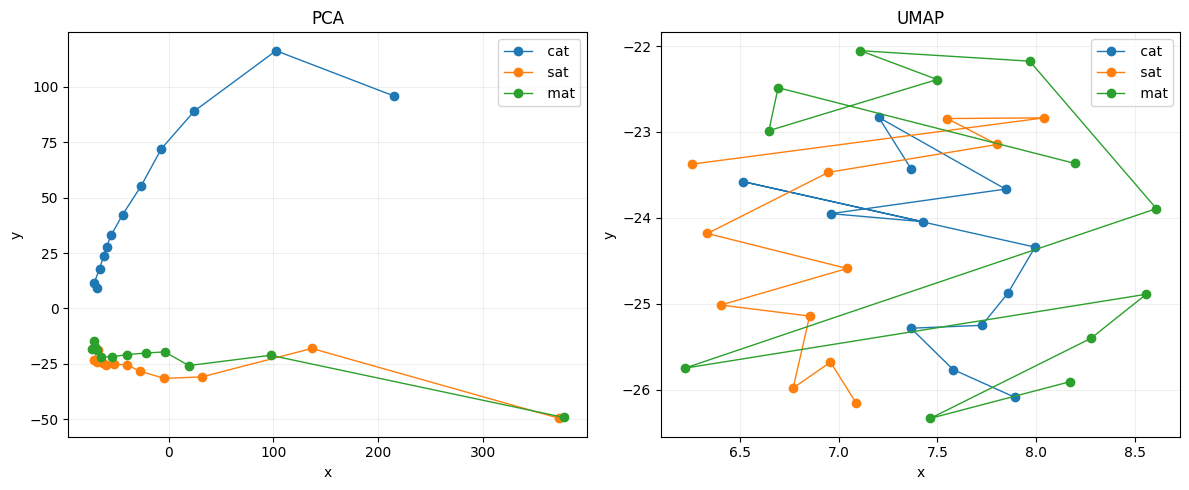

Saved plot: token_trajectories_pca_vs_umap_Steven.png


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: PCA
ax = axes[0]

for idx, name in token_indices.items():
    xs = [p["x"] for p in reduced_traj[idx]]
    ys = [p["y"] for p in reduced_traj[idx]]
    ax.plot(xs, ys, marker="o", linewidth=1, label=name)
    
ax.set_title("PCA")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(alpha=0.2)
ax.legend()

# Right: UMAP
ax = axes[1]

for idx, name in token_indices.items():
    xs = [p["x"] for p in reduced_umap[idx]]
    ys = [p["y"] for p in reduced_umap[idx]]
    ax.plot(xs, ys, marker="o", linewidth=1, label=name)
    
ax.set_title("UMAP")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(alpha=0.2)
ax.legend()

plt.tight_layout()
plt.savefig("token_trajectories_pca_vs_umap_Steven.png", dpi=150)
plt.show()

print("Saved plot: token_trajectories_pca_vs_umap_Steven.png")

## Observations
- PCA highlights larger directional changes across layers, while UMAP focuses more on local relationships rather than global structure.
- Because GPT-2 small only has a small number of layers, with a tiny dataset (short sentence), UMAP does not form clear clusters here. With more data points or tokens, its clustering behavior might become more obvious.
- Overall, PCA makes trajectory changes easier to see across layers, while UMAP highlights relative proximity between tokens. For this project, PCA currently feels more interpretable, and I am still exploring how UMAP could be used meaningfully.

## Additional Test (longer sentence with more tokens selected)

Tokens: [(0, '<|endoftext|>'), (1, 'Gab'), (2, 'riel'), (3, 'le'), (4, ','), (5, ' Mario'), (6, ','), (7, ' Polly'), (8, ','), (9, ' and'), (10, ' Steven'), (11, ' are'), (12, ' building'), (13, ' 3'), (14, ' AI'), (15, ' interpret'), (16, 'ability'), (17, ' interfaces'), (18, '.')]


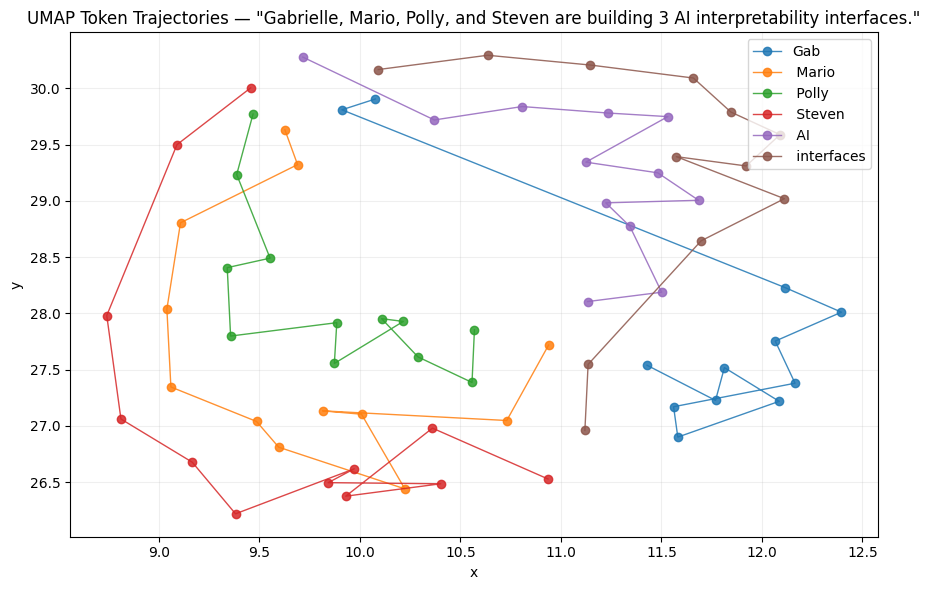

Saved plot: token_trajectories_umap_explore_Steven.png


In [12]:
# Test UMAP on a longer sentence
text = "Gabrielle, Mario, Polly, and Steven are building 3 AI interpretability interfaces."

# Inspect tokens first
tokens = model.to_str_tokens(text)
print("Tokens:", list(enumerate(tokens)))

# Select multiple tokens
token_indices = {
    tokens.index("Gab"): "Gab",
    tokens.index(" Mario"): " Mario",
    tokens.index(" Polly"): " Polly",
    tokens.index(" Steven"): " Steven",
    tokens.index(" AI"): " AI",
    tokens.index(" interfaces"): " interfaces",
}

raw_trajectories = {
    idx: get_token_trajectory(text, idx)
    for idx in token_indices
}

# Reduce using UMAP
reduced_umap = reduce_trajectories_umap(raw_trajectories)

# Plot
plt.figure(figsize=(9,6))

for idx, label in token_indices.items():
    xs = [p["x"] for p in reduced_umap[idx]]
    ys = [p["y"] for p in reduced_umap[idx]]
    
    plt.plot(xs, ys, marker="o", linewidth=1, alpha=0.85, label=label)

plt.title(f"UMAP Token Trajectories — \"{text}\"")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("token_trajectories_umap_explore_Steven.png", dpi=150)
plt.show()

print("Saved plot: token_trajectories_umap_explore_Steven.png")